In [1]:
import os
import sys
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

sys.path.append("../code")
from tree import *
from rules import *
from tree_rules import tree_to_rules
from distances import *
from rule_clustering import *
from tools import visualize_tree
from tools import *

%load_ext autoreload
%autoreload 2

In [80]:
n = 2000
m = 2
k = 3
data, labels = datasets.make_blobs(n_samples=n, centers=k, n_features=m)
data = preprocessing.MinMaxScaler().fit_transform(data)
centers = np.random.uniform(size=(10,m))
median = np.median(data, axis = 0)

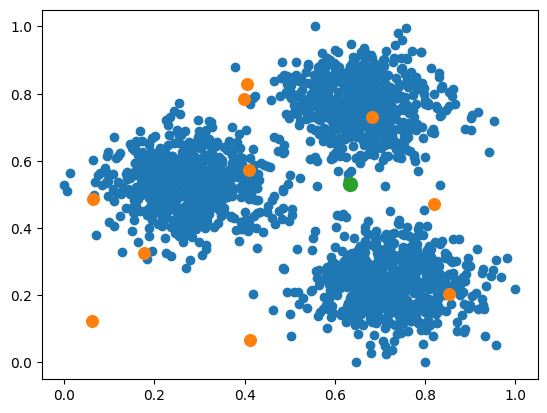

In [85]:
plt.scatter(data[:,0], data[:,1])
plt.scatter(centers[:,0], centers[:,1], s = 70)
plt.scatter(median[0], median[1], s = 100)

In [82]:
def check(data, centers):
    median = np.median(data, axis = 0)
    min_data = None
    min_data_val = np.inf
    min_median = None
    min_median_val = np.inf
    for i in range(len(centers)):
        data_dist = np.sum(np.abs(data - centers[i,:]))
        if data_dist < min_data_val:
            min_data = centers[i,:]
            min_data_val = data_dist

        median_dist = np.sum(np.abs(median - centers[i,:]))
        if median_dist < min_median_val:
            min_median = centers[i,:]
            min_median_val = median_dist

    print(min_data)
    print(min_median)
    return np.all(np.isclose(min_data, min_median))

In [86]:
check(data,centers)

[0.40919127 0.57194971]
[0.82030192 0.47285406]


np.False_

In [74]:
centers

array([[0.90273556, 0.91542355],
       [0.48123695, 0.96613865],
       [0.49213732, 0.03891613],
       [0.53425581, 0.83244294],
       [0.70161027, 0.12837223],
       [0.76633485, 0.87171176],
       [0.74570616, 0.52092557],
       [0.14614749, 0.92930213],
       [0.56073406, 0.42153388],
       [0.11805937, 0.23613961]])

In [75]:
np.sum(np.abs(data - centers[-1,:]))

np.float64(1022.3472285822936)

In [76]:
np.sum(np.abs(data - centers[-2,:]))

np.float64(923.4698836011698)

In [77]:
np.sum(np.abs(median - centers[-1,:]))

np.float64(0.31210007040618915)

In [78]:
np.sum(np.abs(median - centers[-2,:]))

np.float64(0.3330106106006223)

In [84]:
for sample in range(10000):
    n = 2000
    m = 2
    k = 3
    data, labels = datasets.make_blobs(n_samples=n, centers=k, n_features=m)
    data = preprocessing.MinMaxScaler().fit_transform(data)
    centers = np.random.uniform(size=(10,m))
    median = np.median(data, axis = 0)
    if not check(data,centers):
        print('FALSE FOUND')
        break

[0.40919127 0.57194971]
[0.82030192 0.47285406]
FALSE FOUND


## Simple Dataset

In [2]:
n = 2000
m = 2
k = 3

#data = np.random.uniform(0,1,(n,m))
#labels = np.zeros(n)

#data, labels = datasets.make_blobs(n_samples=n, centers=k, n_features=m, random_state=600)
#data = preprocessing.MinMaxScaler().fit_transform(data)

n_samples = 500
random_state = 170
data, labels = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
data = preprocessing.MinMaxScaler().fit_transform(data)

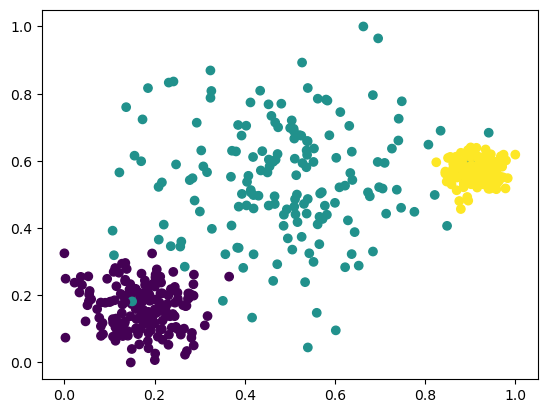

In [3]:
plt.scatter(data[:,0], data[:,1], c = labels)

In [4]:
def plot_decision_boundaries(model, X, ax = None):
    # Define the axis boundaries of the plot
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predict the classification for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundaries
    if ax is None:
        plt.contour(xx, yy, Z, levels = len(np.unique(Z)), colors='k', linestyles='dashed')
    else:
        ax.contour(xx, yy, Z, levels = len(np.unique(Z)), colors='k', linestyles='dashed')

### Kmeans baseline

In [5]:
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(data)

C:\Users\kq146\anaconda3\envs\explainable\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


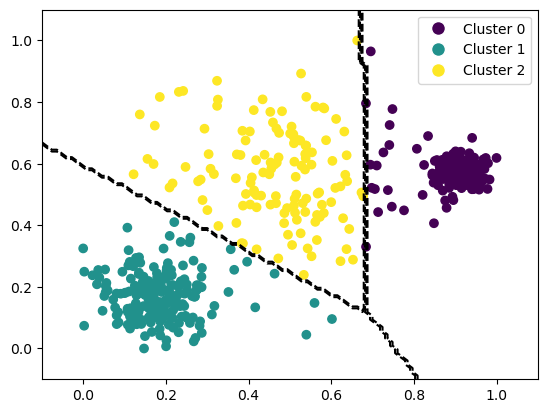

In [6]:
scatter = plt.scatter(data[:,0], data[:,1], c = kmeans.labels_)
plot_decision_boundaries(kmeans, data)

unique_labels = np.unique(kmeans.labels_)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Add legend to plot
plt.legend(handles=handles)

In [7]:
def kmeans_cost(X):
    mu = np.mean(X, axis = 0)
    cost = np.sum(np.linalg.norm(X - mu, axis = 1)**2)
    return cost

def kmedians_cost(X):
    eta = np.median(X, axis = 0)
    cost = np.sum(np.abs(X - eta))
    return cost

def kmeans_labels_cost(X,y):
    total = 0
    for i, label in enumerate(np.unique(y)):
        idxs = np.where(y == label)[0]
        total += kmeans_cost(X[idxs,:])
        
    return total

In [8]:
kmeans_labels_cost(data, kmeans.labels_)

8.937205938854945

### Grid Partition

In [10]:
def rule_grid(data, m):
    # Step 1: Find the min and max of the dataset along both dimensions
    x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
    y_min, y_max = np.min(data[:, 1]), np.max(data[:, 1])

    # Step 2: Calculate the step size for both dimensions
    x_step = (x_max - x_min) / m
    y_step = (y_max - y_min) / m

    # Step 3: Create the grid cells with logical conditions
    grid_cells = []

    for i in range(m):
        for j in range(m):
            x_start = x_min + i * x_step
            x_end = x_start + x_step
            y_start = y_min + j * y_step
            y_end = y_start + y_step
            
            # Logical conditions defining the current cell
            ineq = ['>', '<', '>', '<']
            if i == 0:
                ineq[0] = '>='
            elif i == m - 1:
                ineq[1] = '<='
            if j == 0:
                ineq[2] = '>='
            elif j == m - 1:
                ineq[3] = '<='
                
            cell_conditions = [
                Condition(0, ineq[0], x_start),
                Condition(0, ineq[1], x_end),
                Condition(1, ineq[2], y_start),
                Condition(1, ineq[3], y_end)
            ]
            
            grid_cells.append(Rule([Term(cell_conditions)]))

    return grid_cells

In [11]:
cells = 5
grid = rule_grid(data,cells)
grid_rules = RuleClustering(grid, k_clusters = cells**2)
grid_rules.fit_rules(data)
grid_labels = grid_rules.predict(data)

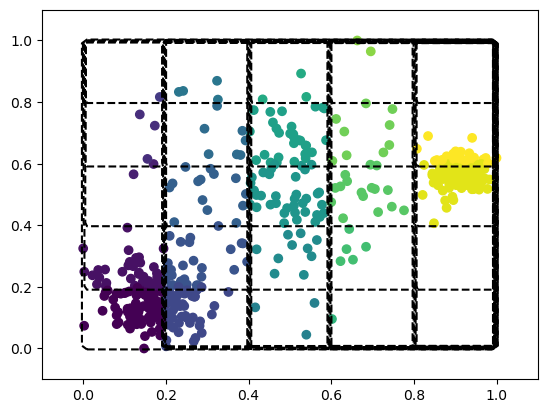

In [12]:
#scatter = plt.scatter(data2[select,0], data2[select,1])
scatter = plt.scatter(data[:,0], data[:,1], c = grid_labels)
plot_decision_boundaries(grid_rules, data)

### k-Means Tree Partition

In [9]:
kmeans_tree = kMeansTree(max_leaf_nodes = 16, min_points_leaf = 1)
kmeans_tree.fit(data)
kmeans_tree_labels = kmeans_tree.predict(data)

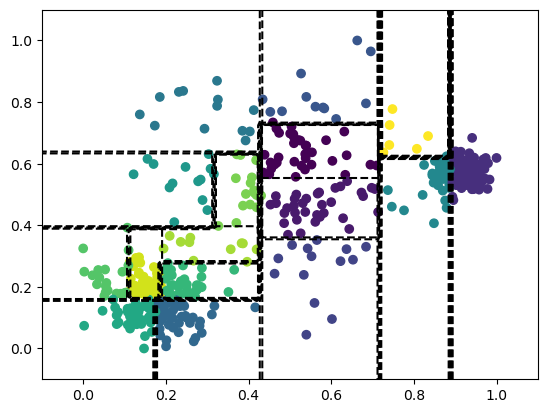

In [10]:
scatter = plt.scatter(data[:,0], data[:,1], c = kmeans_tree_labels)
plot_decision_boundaries(kmeans_tree, data)

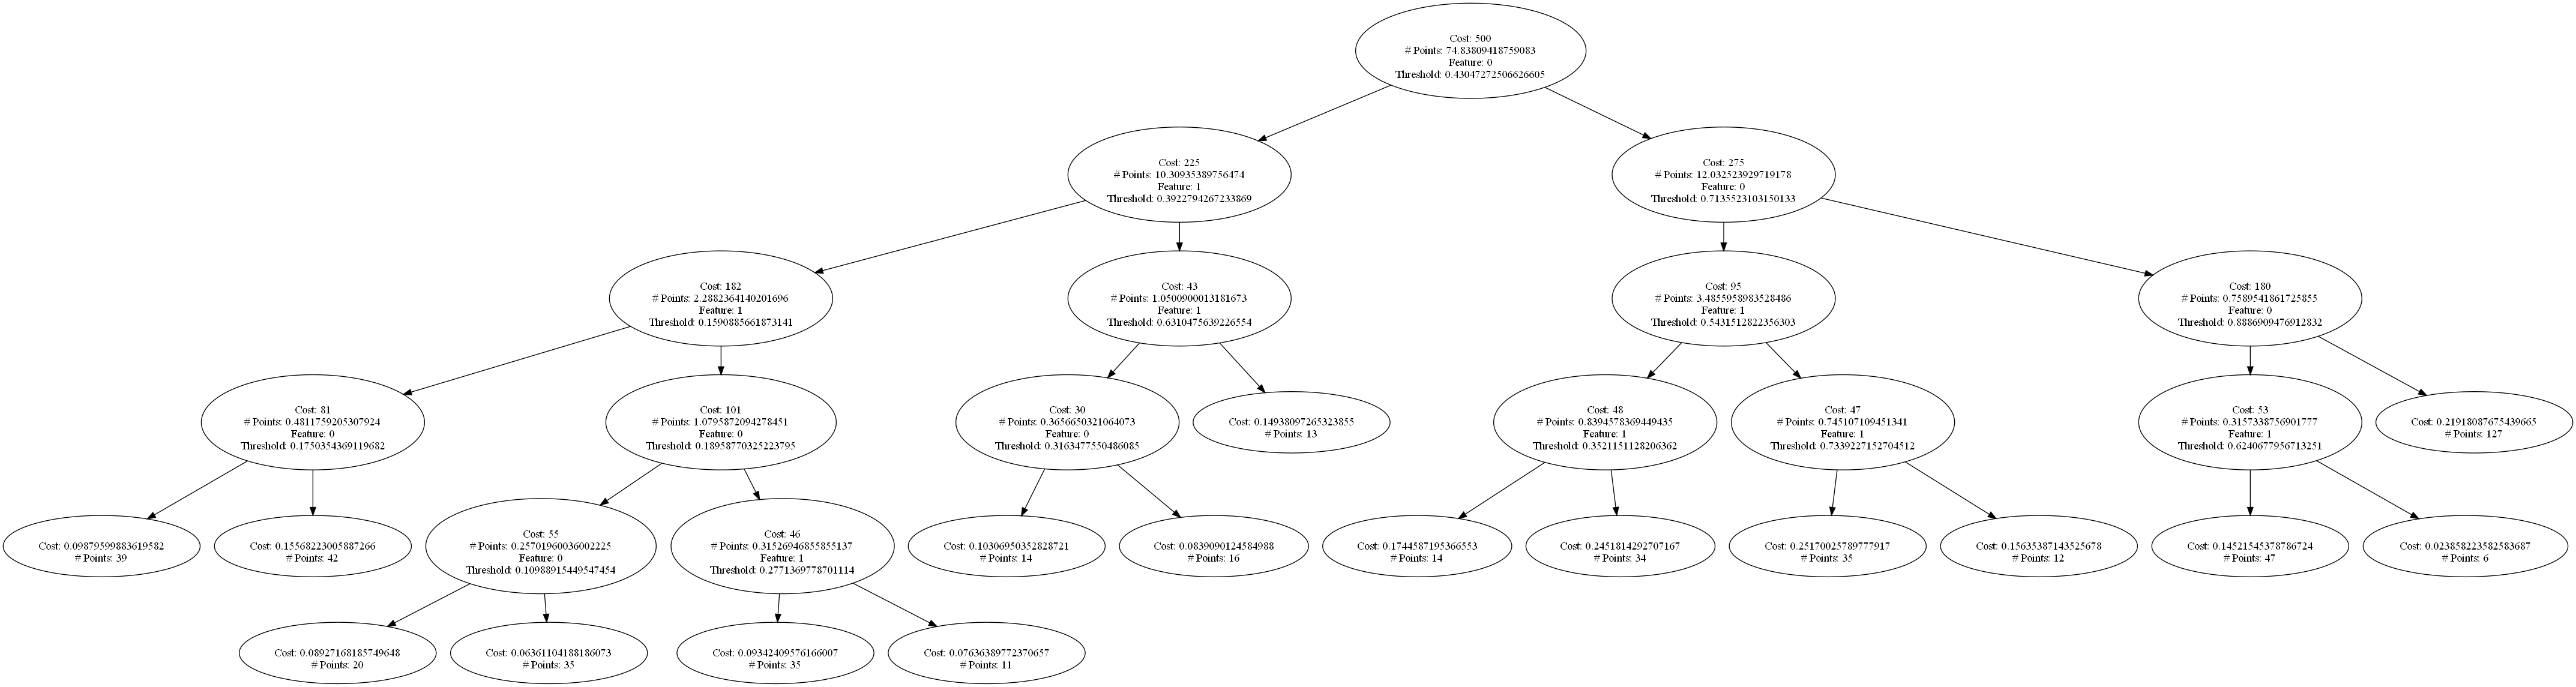

In [11]:
visualize_tree(kmeans_tree.root)

In [12]:
kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)

In [13]:
kmeans_rules

[(x0 <= 0.43047272506626605  ∧  x1 <= 0.3922794267233869  ∧  x1 <= 0.1590885661873141  ∧  x0 <= 0.1750354369119682),
 (x0 <= 0.43047272506626605  ∧  x1 <= 0.3922794267233869  ∧  x1 <= 0.1590885661873141  ∧  x0 > 0.1750354369119682),
 (x0 <= 0.43047272506626605  ∧  x1 <= 0.3922794267233869  ∧  x1 > 0.1590885661873141  ∧  x0 <= 0.18958770325223795  ∧  x0 <= 0.10988915449547454),
 (x0 <= 0.43047272506626605  ∧  x1 <= 0.3922794267233869  ∧  x1 > 0.1590885661873141  ∧  x0 <= 0.18958770325223795  ∧  x0 > 0.10988915449547454),
 (x0 <= 0.43047272506626605  ∧  x1 <= 0.3922794267233869  ∧  x1 > 0.1590885661873141  ∧  x0 > 0.18958770325223795  ∧  x1 <= 0.2771369778701114),
 (x0 <= 0.43047272506626605  ∧  x1 <= 0.3922794267233869  ∧  x1 > 0.1590885661873141  ∧  x0 > 0.18958770325223795  ∧  x1 > 0.2771369778701114),
 (x0 <= 0.43047272506626605  ∧  x1 > 0.3922794267233869  ∧  x1 <= 0.6310475639226554  ∧  x0 <= 0.3163477550486085),
 (x0 <= 0.43047272506626605  ∧  x1 > 0.3922794267233869  ∧  x1 <= 0.6

In [18]:
leaves = list(range(1,32))
cost_by_leaves = []
for l in leaves:
    kmeans_tree = kMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)

    cost_sum = 0
    for r in kmeans_rules:
        r.fit(data)
        cost_sum += kmeans_cost(r.satisfied_points)

    cost_by_leaves.append(cost_sum)

In [30]:
cost = kmeans_labels_cost(data, kmeans.labels_)
upper_bound = 4*cost + 6*np.array(cost_by_leaves)
dasgupta = k**2 * cost
svensson = k * (np.log(k)**2) * cost

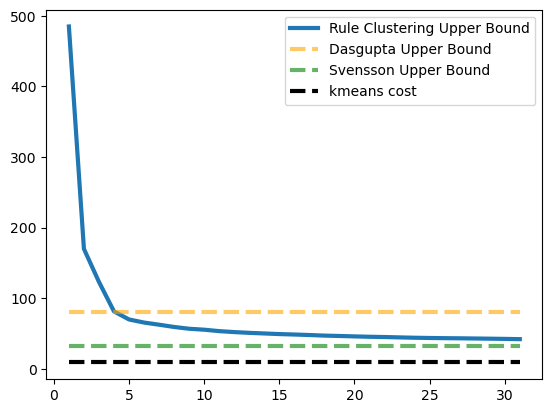

In [31]:
plt.plot(leaves, upper_bound, linewidth = 3, label = 'Rule Clustering Upper Bound')
plt.hlines(dasgupta, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'Dasgupta Upper Bound', linewidth = 3, color = 'orange', alpha = 0.6)
plt.hlines(svensson, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'Svensson Upper Bound', linewidth = 3, color = 'green', alpha = 0.6)
plt.hlines(kmeans_labels_cost(data, kmeans.labels_), xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
plt.legend()

### k-Medians Tree Partition

In [274]:
kmedians_tree = kMediansTree(max_leaf_nodes = 16, min_points_leaf = 1)
kmedians_tree.fit(data)
kmedians_tree_labels = kmedians_tree.predict(data)

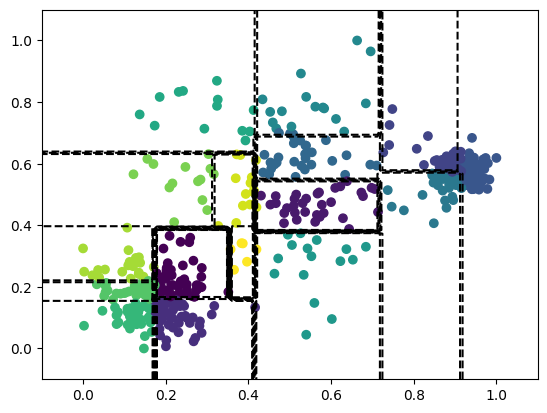

In [275]:
scatter = plt.scatter(data[:,0], data[:,1], c = kmedians_tree_labels)
plot_decision_boundaries(kmedians_tree, data)

In [276]:
kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)

# Rule Clustering

### 1. k-Means

In [27]:
kmeans_cluster = kMeansRuleClustering(kmeans_rules, k_clusters = k, iterations = 1000)
kmeans_cluster.fit(data)
kmeans_cluster_labels = kmeans_cluster.predict(data)

In [28]:
kmeans_cluster.iterations

4

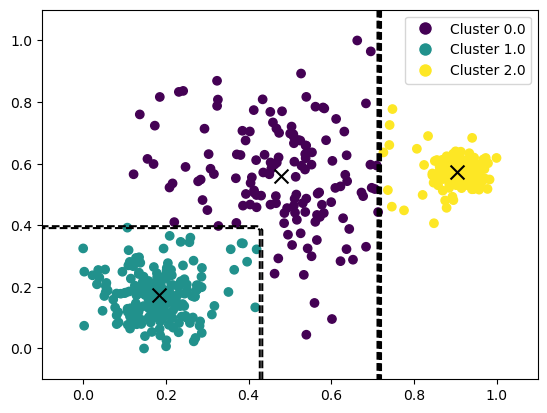

In [29]:
scatter = plt.scatter(data[:,0], data[:,1], c = kmeans_cluster_labels)
plt.scatter(kmeans_cluster.centers[:,0], kmeans_cluster.centers[:,1], color = 'k', marker = 'x', s = 100)
plot_decision_boundaries(kmeans_cluster, data)

unique_labels = np.unique(kmeans_cluster_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') 
           if label != -1 else plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') 
        for label in unique_labels]

# Add legend to plot
plt.legend(handles=handles)

In [42]:
print(kmeans_cluster)

IF:
(x0 <= 0.43047272506626605  ∧  x1 > 0.3922794267233869)  ∨  
(x0 > 0.43047272506626605  ∧  x0 <= 0.7135523103150133)
THEN CLUSTER 0

IF:
(x0 <= 0.43047272506626605  ∧  x1 <= 0.3922794267233869)
THEN CLUSTER 1

IF:
(x0 > 0.7135523103150133)
THEN CLUSTER 2



In [43]:
leaves = list(range(4,32))
cost_by_leaves = []
for l in leaves:
    kmeans_tree = kMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    
    kmeans_cluster = kMeansRuleClustering(kmeans_rules, k_clusters = 4, iterations = 100)
    kmeans_cluster.fit(data)
    kmeans_cluster_labels = kmeans_cluster.predict(data)

    cluster_cost = kmeans_labels_cost(data, kmeans_cluster_labels)
    cost_by_leaves.append(cluster_cost)

C:\Users\kq146\anaconda3\envs\explainable\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kq146\anaconda3\envs\explainable\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kq146\anaconda3\envs\explainable\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kq146\anaconda3\envs\explainable\Lib\site-packages\sklearn\cluster\_kmeans.p

In [44]:
# Svensson Random Tree for comparison:
random_tree_cost = np.inf
for i in range(10000):
    random_tree = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree.fit(kmeans.cluster_centers_)
    random_tree_labels = random_tree.predict(data)
    rcost = kmeans_labels_cost(data, random_tree_labels)
    if rcost < random_tree_cost:
        random_tree_cost = rcost

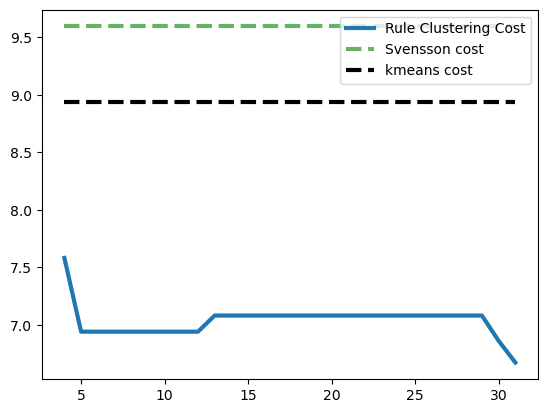

In [45]:
plt.plot(leaves, cost_by_leaves, linewidth = 3, label = 'Rule Clustering Cost')
plt.hlines(random_tree_cost, xmin = leaves[0], xmax = leaves[-1], color = 'green', linestyle = '--', label = 'Svensson cost', linewidth = 3, alpha = 0.6)
plt.hlines(kmeans_labels_cost(data, kmeans.labels_), xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
plt.legend()

### 2. k-Medians

In [278]:
kmedians_cluster = kMediansRuleClustering(kmedians_rules, k_clusters = k, iterations = 1000)
kmedians_cluster.fit(data)
kmedians_cluster_labels = kmedians_cluster.predict(data)

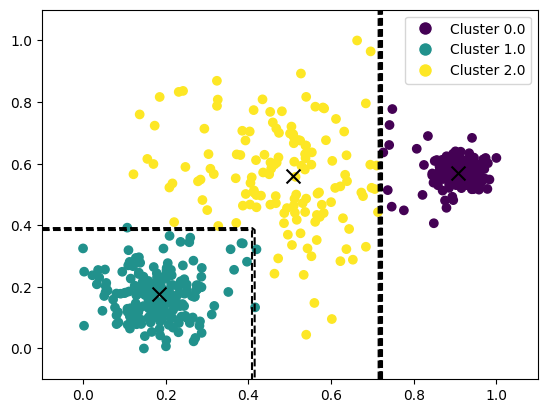

In [279]:
scatter = plt.scatter(data[:,0], data[:,1], c = kmedians_cluster_labels)
plt.scatter(kmedians_cluster.centers[:,0], kmedians_cluster.centers[:,1], color = 'k', marker = 'x', s = 100)
plot_decision_boundaries(kmedians_cluster, data)

# Add legend to plot
plt.legend(handles=handles)

### 3. Agglomerative

In [293]:
rule_list = kmeans_rules

In [294]:
D_hausdorff = compute_distance_matrix(data, rule_list, rule_hausdorff_distance)
D_single = compute_distance_matrix(data, rule_list, rule_single_linkage_distance)

In [297]:
AggCluster = AgglomerativeRuleClustering(rule_list, k_clusters = k, linkage = 'single')
AggCluster.fit(data, D_single)
AggCluster_labels = AggCluster.predict(data)

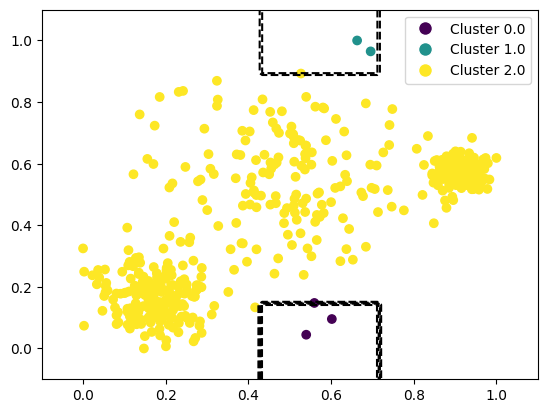

In [298]:
scatter = plt.scatter(data[:,0], data[:,1], c = AggCluster_labels)
plot_decision_boundaries(AggCluster, data)

unique_labels = np.unique(AggCluster_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') 
           if label != -1 else plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') 
        for label in unique_labels]

# Add legend to plot
plt.legend(handles=handles)

# Clustering Demonstration

In [299]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), np.zeros(n_samples)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

dataset_list = [noisy_circles, noisy_moons, blobs, aniso, varied, no_structure]

C:\Users\kq146\AppData\Local\Temp\ipykernel_15148\4141601859.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


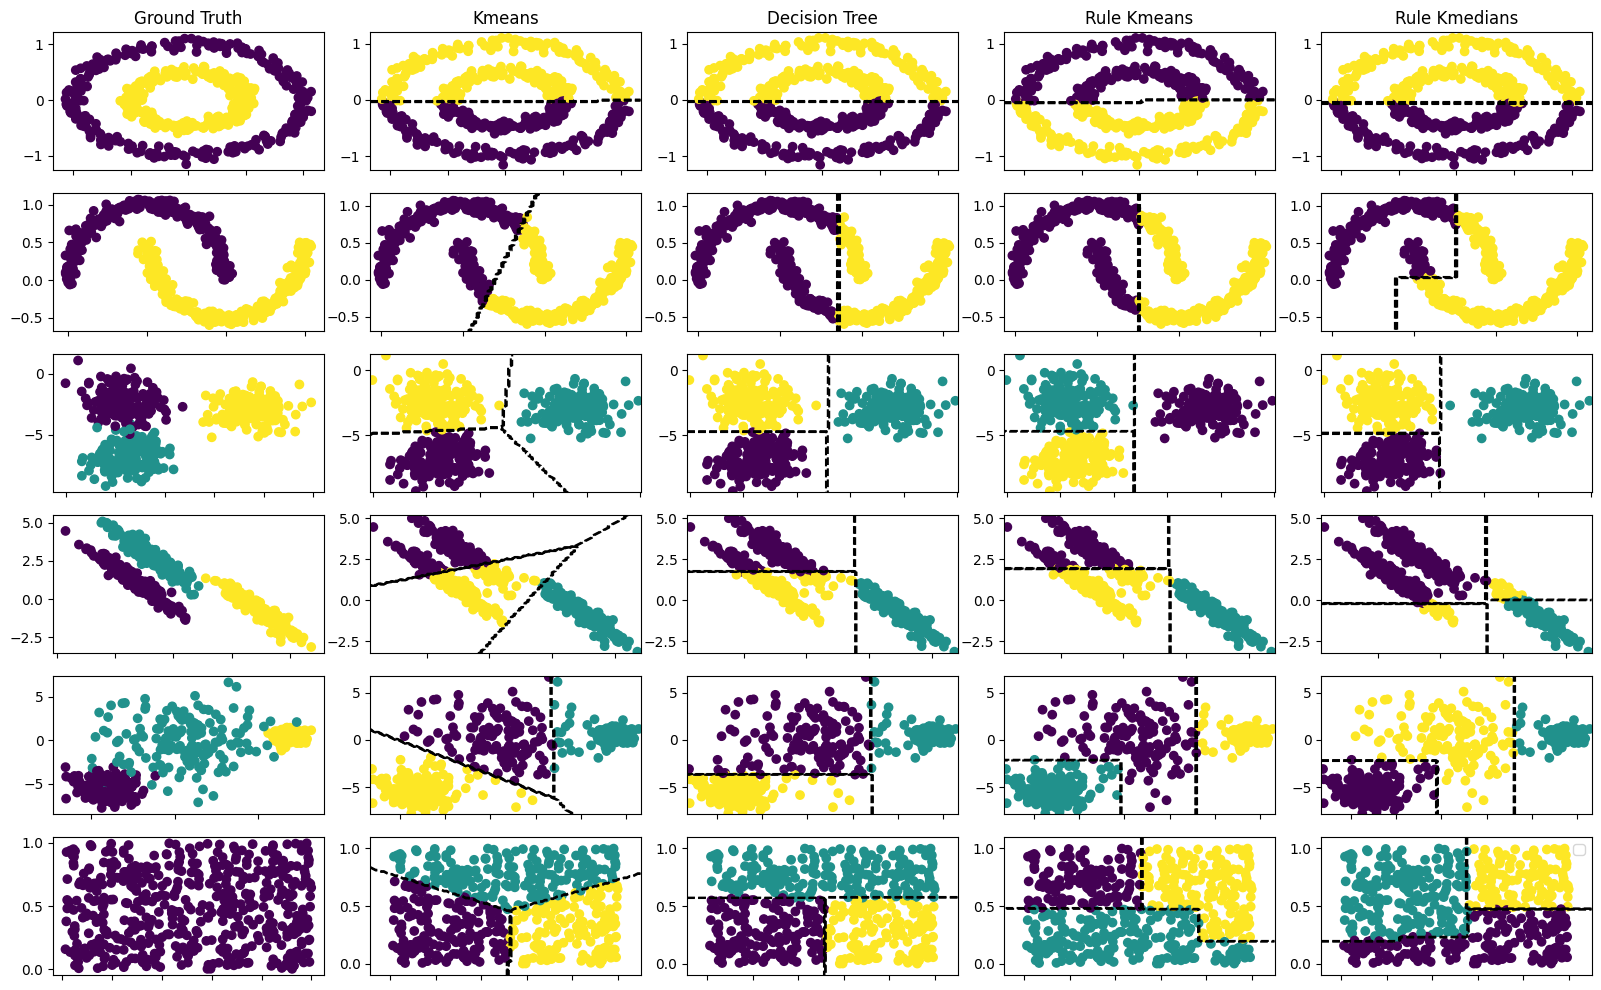

In [300]:
# Cluster and display Results
fig,axes = plt.subplots(6,5, figsize = (16,10))

# For each of the datasets do clusters
for d in range(len(dataset_list)):
    # Set titles
    if d == 0:
        axes[d,0].set_title('Ground Truth')
        axes[d,1].set_title('Kmeans')
        axes[d,2].set_title('Decision Tree')
        axes[d,3].set_title('Rule Kmeans')
        axes[d,4].set_title('Rule Kmedians')
        #axes[d,5].set_title('Rule Agglomerative')
    
    X,y = dataset_list[d]

    # determine the number of clusters
    if np.sum(y) == 0:
        n_clusters = 3
    else:
        n_clusters = len(np.unique(y))

    # Baseline:
    axes[d,0].scatter(X[:,0], X[:,1], c = y)
    axes[d,0].set_xticklabels([])

    # Kmeans:
    kmeans = KMeans(n_clusters=n_clusters, random_state=39, n_init="auto").fit(X)
    axes[d,1].scatter(X[:,0], X[:,1], c = kmeans.labels_)
    plot_decision_boundaries(kmeans, X, ax = axes[d,1])
    axes[d,1].set_xticklabels([])

    # Decision tree
    tree = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = n_clusters).fit(X, kmeans.labels_)
    tree_labels = tree.predict(X)
    axes[d,2].scatter(X[:,0], X[:,1], c = tree_labels)
    plot_decision_boundaries(tree, X, ax = axes[d,2])
    axes[d,2].set_xticklabels([])

    # Rule K-means
    kmeans_tree = kMeansTree(max_leaf_nodes = 16, min_points_leaf = 1)
    kmeans_tree.fit(X)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    kmeans_cluster = kMeansRuleClustering(kmeans_rules, k_clusters = n_clusters, iterations = 1000)
    kmeans_cluster.fit(X)
    kmeans_cluster_labels = kmeans_cluster.predict(X)
    
    axes[d,3].scatter(X[:,0], X[:,1], c = kmeans_cluster_labels)
    plot_decision_boundaries(kmeans_cluster, X, ax = axes[d,3])
    #axes[d,3].scatter(kmeans_cluster.centers[:,0], kmeans_cluster.centers[:,1], color = 'red', marker = 'x', s = 100)
    axes[d,3].set_xticklabels([])

    # Rule k-Medians
    kmedians_tree = kMediansTree(max_leaf_nodes = 16, min_points_leaf = 1)
    kmedians_tree.fit(X)
    kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)
    kmedians_cluster = kMediansRuleClustering(kmedians_rules, k_clusters = n_clusters, iterations = 1000)
    kmedians_cluster.fit(X)
    kmedians_cluster_labels = kmedians_cluster.predict(X)
    axes[d,4].scatter(X[:,0], X[:,1], c = kmedians_cluster_labels)
    plot_decision_boundaries(kmedians_cluster, X, ax = axes[d,4])
    axes[d,4].set_xticklabels([])

    # Rule Agglomerative:
    '''
    D_single = compute_distance_matrix(X, kmeans_rules, rule_single_linkage_distance)
    AggCluster = AgglomerativeRuleClustering(kmeans_rules, k_clusters = 4, linkage = 'single')
    AggCluster.fit(X, D_single)
    AggCluster_labels = AggCluster.predict(X)
    
    axes[d,5].scatter(X[:,0], X[:,1], c = AggCluster_labels)
    plot_decision_boundaries(AggCluster, X, ax = axes[d,5])
    unique_labels = np.unique(AggCluster_labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') for label in unique_labels if label == -1]
    axes[d,5].legend(handles=handles)
    axes[d,5].set_xticklabels([])
    '''
        

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    #ax.plot(x, y)
    
    # Hide x-axis labels for all subplots except those in the last row
    if i < 5 * 5:  # If the subplot is not in the last row
        ax.set_xticklabels([])

# Adjust the layout
plt.tight_layout()
plt.legend()